# Conditional GAN - MNIST

Make Your First GAN With PyTorch, 2020

In [1]:
from rich import print

## import libraries

In [2]:
import random

import torch
import torch.nn as nn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Dataset Class

In [3]:
import mnist_data

In [4]:
# load training data

train_csv = mnist_data.datadir.joinpath('mnist_train.csv')
mnist_dataset = mnist_data.MnistDataset(train_csv)

<Figure size 432x288 with 1 Axes>

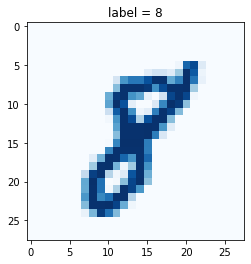

In [5]:
# check data contains images

mnist_dataset.plot_image(17)

## Data Functions

In [6]:
# functions to generate random data

def generate_random_image(size):
    random_data = torch.rand(size)
    return random_data


def generate_random_seed(size):
    random_data = torch.randn(size)
    return random_data

# size here must only be an integer
def generate_random_one_hot(size):
    label_tensor = torch.zeros((size))
    random_idx = random.randint(0,size-1)
    label_tensor[random_idx] = 1.0
    return label_tensor

## Discriminator Network

In [7]:
# discriminator class

class Discriminator(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers
        self.model = nn.Sequential(
            nn.Linear(784+10, 200),
            nn.LeakyReLU(0.02),

            nn.LayerNorm(200),

            nn.Linear(200, 1),
            nn.Sigmoid()
        )
        
        # create loss function
        self.loss_function = nn.BCELoss()

        # create optimiser
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []
    
    
    def forward(self, image_tensor, label_tensor):
        # combine seed and label
        inputs = torch.cat((image_tensor, label_tensor))
        return self.model(inputs)
    
    
    def train(self, inputs, label_tensor, targets):
        # calculate the output of the network
        outputs = self.forward(inputs, label_tensor)
        
        # calculate loss
        loss = self.loss_function(outputs, targets)

        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            
        if (self.counter % 10000 == 0):
            print("counter = ", self.counter)

        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()
    
    
    def plot_progress(self):
        df = pd.DataFrame(self.progress, columns=['loss'])
        plt_kwagrs = dict(
            ylim=(min(self.progress), max(self.progress)), 
            figsize=(16,8), 
            alpha=0.1, 
            marker='.', 
            grid=True, 
            yticks=(0, 0.25, 0.5, 1.0, 5.0)
        )
        df.plot()

## Test Discriminator

In [8]:
%%time
# test discriminator can separate real data from random noise

D = Discriminator()

for label, image_data_tensor, label_tensor in mnist_dataset:
    # real data
    D.train(image_data_tensor, label_tensor, torch.FloatTensor([1.0]))
    # fake data
    D.train(generate_random_image(784), generate_random_one_hot(10), torch.FloatTensor([0.0]))

counter =  10000

counter =  20000

counter =  30000

counter =  40000

counter =  50000

counter =  60000

counter =  70000

counter =  80000

counter =  90000

counter =  100000

counter =  110000

counter =  120000

CPU times: user 1h 47min 39s, sys: 1h 49min 32s, total: 3h 37min 11s
Wall time: 12min 12s


<Figure size 432x288 with 1 Axes>

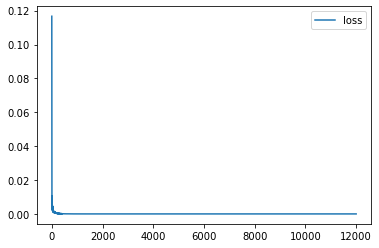

In [9]:
# plot discriminator loss

D.plot_progress()

In [10]:
# manually run discriminator to check it can tell real data from fake

for i in range(4):
    label, image_data_tensor, label_tensor = mnist_dataset[random.randint(0,60000)]
    print( D.forward( image_data_tensor, label_tensor ).item() )

for i in range(4):
    print( D.forward( generate_random_image(784), generate_random_one_hot(10) ).item() )

1.0

1.0

1.0

1.0

9.535317847808589e-12

8.55430309920635e-12

9.428129284227982e-12

9.356829547280121e-12

## Generator Network

In [11]:
class Generator(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers
        self.model = nn.Sequential(
            nn.Linear(100+10, 200),
            nn.LeakyReLU(0.02),

            nn.LayerNorm(200),

            nn.Linear(200, 784),
            nn.Sigmoid()
        )
        
        # create optimiser, simple stochastic gradient descent
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []
        
    
    def forward(self, seed_tensor, label_tensor):        
        # combine seed and label
        inputs = torch.cat((seed_tensor, label_tensor))
        return self.model(inputs)


    def train(self, D, inputs, label_tensor, targets):
        # calculate the output of the network
        g_output = self.forward(inputs, label_tensor)
        
        # pass onto Discriminator
        d_output = D.forward(g_output, label_tensor)
        
        # calculate error
        loss = D.loss_function(d_output, targets)

        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass

        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

    
    def plot_images(self, label):
        label_tensor = torch.zeros((10))
        label_tensor[label] = 1.0
        # plot a 3 column, 2 row array of sample images
        f, axarr = plt.subplots(2,3, figsize=(16,8))
        for i in range(2):
            for j in range(3):
                axarr[i,j].imshow(G.forward(generate_random_seed(100), label_tensor).detach().cpu().numpy().reshape(28,28), interpolation='none', cmap='Blues')
                
    
    def plot_progress(self):
        df = pd.DataFrame(self.progress, columns=['loss'])
        plt_kwagrs = dict(
            ylim=(min(self.progress), max(self.progress)), 
            figsize=(16, 8), 
            alpha=0.1, 
            marker='.', 
            grid=True, 
            yticks=(0, 0.25, 0.5, 1.0, 5.0)
        )
        df.plot()

## Test Generator Output

<matplotlib.image.AxesImage object at 0x7f6a5061f760>

<Figure size 432x288 with 1 Axes>

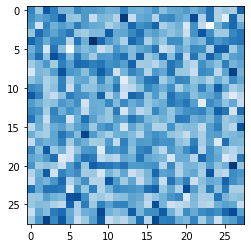

In [12]:
# check the generator output is of the right type and shape

G = Generator()

output = G.forward(generate_random_seed(100), generate_random_one_hot(10))

img = output.detach().numpy().reshape(28,28)

plt.imshow(img, interpolation='none', cmap='Blues')

## Train GAN

In [13]:
# create Discriminator and Generator

D = Discriminator()
G = Generator()

In [14]:
%%time 

# train Discriminator and Generator

epochs = 12

for epoch in range(epochs):
    print ("epoch = ", epoch + 1)

    # train Discriminator and Generator
    for label, image_data_tensor, label_tensor in mnist_dataset:
        # train discriminator on true
        D.train(image_data_tensor, label_tensor, torch.FloatTensor([1.0]))

        # random 1-hot label for generator
        random_label = generate_random_one_hot(10)

        # train discriminator on false
        # use detach() so gradients in G are not calculated
        D.train(G.forward(generate_random_seed(100), random_label).detach(), random_label, torch.FloatTensor([0.0]))

        # different random 1-hot label for generator
        random_label = generate_random_one_hot(10)

        # train generator
        G.train(D, generate_random_seed(100), random_label, torch.FloatTensor([1.0]))

epoch =  1

counter =  10000

counter =  20000

counter =  30000

counter =  40000

counter =  50000

counter =  60000

counter =  70000

counter =  80000

counter =  90000

counter =  100000

counter =  110000

counter =  120000

epoch =  2

counter =  130000

counter =  140000

counter =  150000

counter =  160000

counter =  170000

counter =  180000

counter =  190000

counter =  200000

counter =  210000

counter =  220000

counter =  230000

counter =  240000

epoch =  3

counter =  250000

counter =  260000

counter =  270000

counter =  280000

counter =  290000

counter =  300000

counter =  310000

counter =  320000

counter =  330000

counter =  340000

counter =  350000

counter =  360000

epoch =  4

counter =  370000

counter =  380000

counter =  390000

counter =  400000

counter =  410000

counter =  420000

counter =  430000

counter =  440000

counter =  450000

counter =  460000

counter =  470000

counter =  480000

epoch =  5

counter =  490000

counter =  500000

counter =  510000

counter =  520000

counter =  530000

counter =  540000

counter =  550000

counter =  560000

counter =  570000

counter =  580000

counter =  590000

counter =  600000

epoch =  6

counter =  610000

counter =  620000

counter =  630000

counter =  640000

counter =  650000

counter =  660000

counter =  670000

counter =  680000

counter =  690000

counter =  700000

counter =  710000

counter =  720000

epoch =  7

counter =  730000

counter =  740000

counter =  750000

counter =  760000

counter =  770000

counter =  780000

counter =  790000

counter =  800000

counter =  810000

counter =  820000

counter =  830000

counter =  840000

epoch =  8

counter =  850000

counter =  860000

counter =  870000

counter =  880000

counter =  890000

counter =  900000

counter =  910000

counter =  920000

counter =  930000

counter =  940000

counter =  950000

counter =  960000

epoch =  9

counter =  970000

counter =  980000

counter =  990000

counter =  1000000

counter =  1010000

counter =  1020000

counter =  1030000

counter =  1040000

counter =  1050000

counter =  1060000

counter =  1070000

counter =  1080000

epoch =  10

counter =  1090000

counter =  1100000

counter =  1110000

counter =  1120000

counter =  1130000

counter =  1140000

counter =  1150000

counter =  1160000

counter =  1170000

counter =  1180000

counter =  1190000

counter =  1200000

epoch =  11

counter =  1210000

counter =  1220000

counter =  1230000

counter =  1240000

counter =  1250000

counter =  1260000

counter =  1270000

counter =  1280000

counter =  1290000

counter =  1300000

counter =  1310000

counter =  1320000

epoch =  12

counter =  1330000

counter =  1340000

counter =  1350000

counter =  1360000

counter =  1370000

counter =  1380000

counter =  1390000

counter =  1400000

counter =  1410000

counter =  1420000

counter =  1430000

counter =  1440000

CPU times: user 1d 19h 4min 34s, sys: 1d 6h 51min 51s, total: 3d 1h 56min 25s
Wall time: 3h 27min 55s


<Figure size 432x288 with 1 Axes>

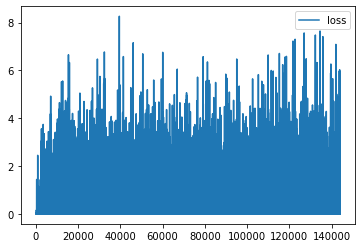

In [15]:
# plot discriminator error

D.plot_progress()

<Figure size 432x288 with 1 Axes>

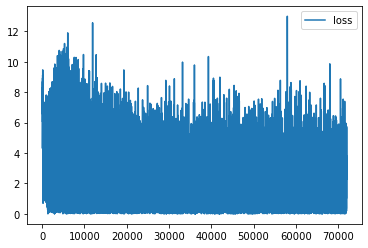

In [16]:
# plot generator error

G.plot_progress()

## Run Generator

<Figure size 1152x576 with 6 Axes>

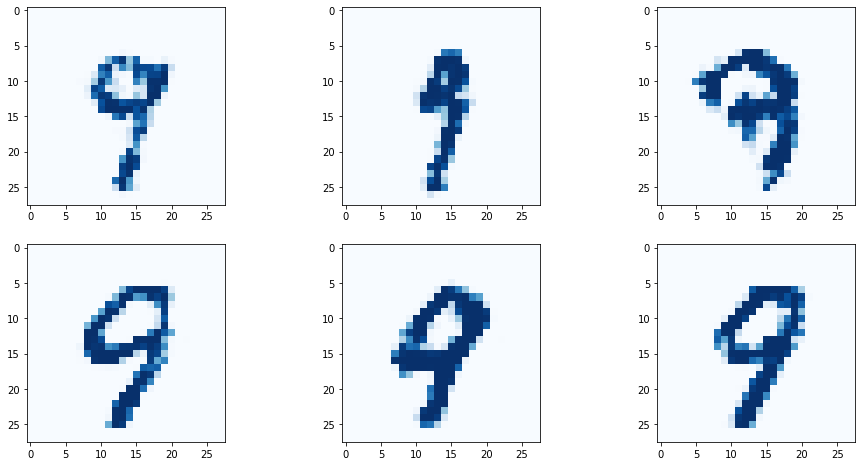

In [17]:
# plot several outputs from the trained generator

G.plot_images(9)

<Figure size 1152x576 with 6 Axes>

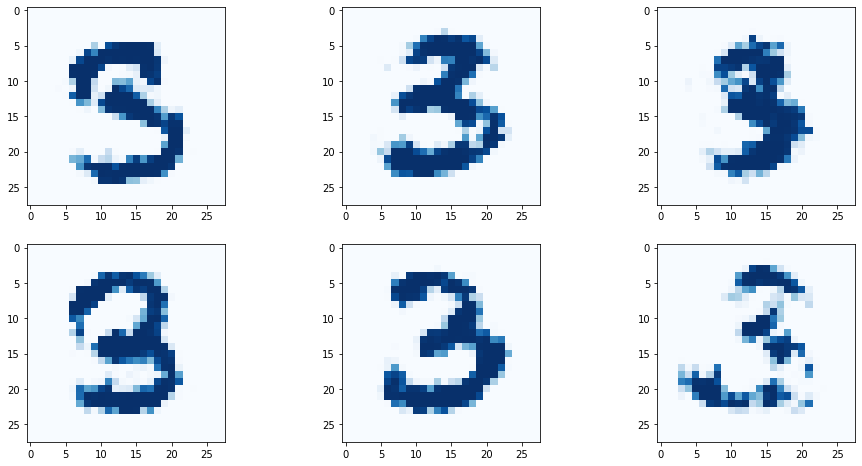

In [18]:
# plot several outputs from the trained generator

G.plot_images(3)

<Figure size 1152x576 with 6 Axes>

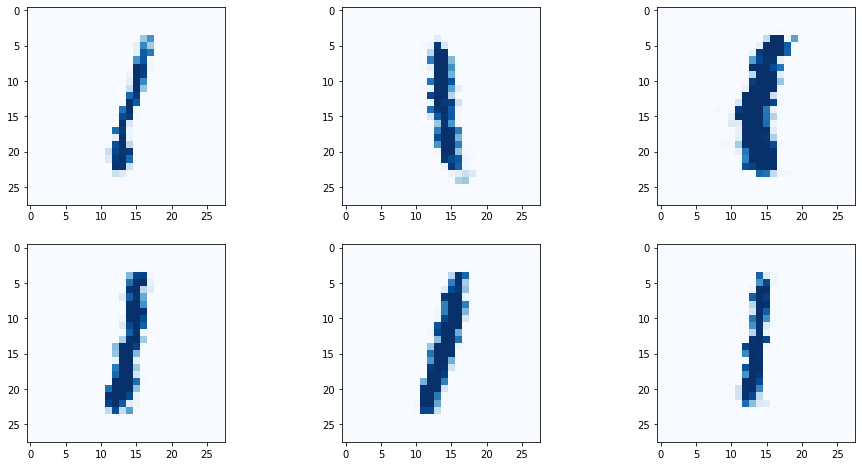

In [19]:
# plot several outputs from the trained generator

G.plot_images(1)

<Figure size 1152x576 with 6 Axes>

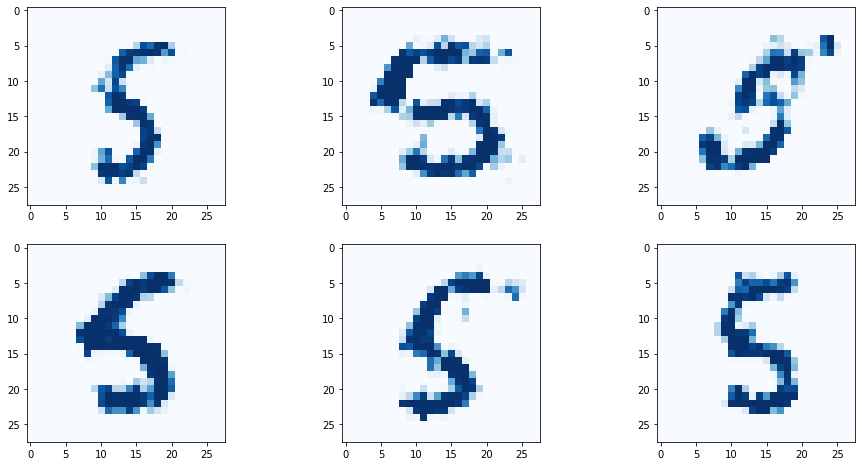

In [20]:
# plot several outputs from the trained generator

G.plot_images(5)

## load from pickled GAN

In [22]:
import dill as pickle

In [23]:
cgan = dict(discriminator=D, generator=G)

with open('cgan_mnist.pkl', 'wb') as f:
    pickle.dump(cgan, f)

In [24]:
with open('cgan_mnist.pkl', 'rb') as f:
    new_cgan = pickle.load(f)

<Figure size 1152x576 with 6 Axes>

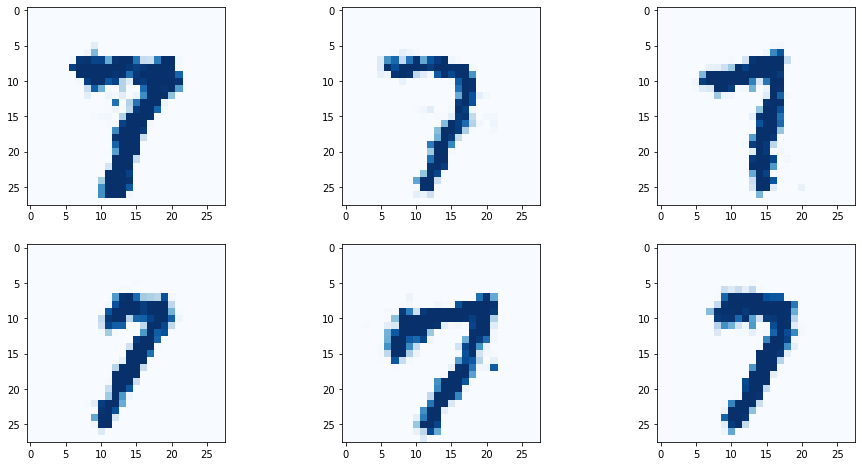

In [37]:
new_cgan['generator'].plot_images(7)